In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import json
import os
import pandas as pd
import seaborn as sns
import glob
from natsort import natsorted
from scipy import stats
from sklearn.metrics import recall_score
from sklearn.metrics import auc as auc_score
from sklearn.metrics import roc_auc_score, roc_curve
sns.set(style="whitegrid")
import matplotlib as mpl
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from matplotlib.ticker import PercentFormatter


In [2]:
def histogram(data):
    amnts, bins = np.histogram(data,bins=[0, 0.5, 1])
    return amnts[-1]/(np.sum(amnts))

def hist_pred(data, thresh=0.5):
    amnts, bins = np.histogram(data,bins=[0, thresh, 1])
    return int(amnts[0] < amnts[-1])

def process_fold(fold, aggregation_function=histogram, prediction_function=hist_pred, make_auc_plot=False):
    aucs = []
    labels = []
    confs = []
    scores = []
    for patient, data in fold.items():
        pred_key = 'predictions'
        label_key = 'label'
        if pred_key not in data:
            pred_key = 'val_predictions'
            label_key = 'val_label'
        if len(data[pred_key]) > 1:
            labels.append(data[label_key])
            confs.append(aggregation_function(data[pred_key]))
            score = int(data[label_key] == prediction_function(data[pred_key]))
            scores.append(score)
        else:
            continue
    auc = roc_auc_score(labels, confs)
    if make_auc_plot:
        fpr, tpr, thresh = roc_curve(labels, confs)
        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC={auc:.4f}')
        plt.legend()
    return auc, np.mean(scores)

In [3]:
def create_mega_fold(run_ids, root_dir='/home/colin/results_cov/', control=False):
    mega_fold = {}
    if control:
        root_dir = os.path.join(root_dir, 'control')
    for run_id in run_ids:
        files = glob.glob(os.path.join(root_dir, f'*{run_id}*.json'))
        assert len(files) == 1
        file = files[0]
        with open(file) as fp:
            all_data = json.load(fp)        
            test_fold = {patient: data for patient, data in all_data.items() if 'predictions' in data}
            for patient, data in test_fold.items():
                if patient in mega_fold:
                    mega_fold[patient]['predictions'] += data['predictions']
                else:
                    mega_fold[patient] = data
    return mega_fold

def denormalize_image(image, mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    image = image.clone()
    image = image * torch.tensor(std).view(3, 1, 1)
    image = image + torch.tensor(mean).view(3, 1, 1)
    return image.permute(1, 2, 0)

# LOADING MIL MODEL

In [2]:
import sys
sys.path.append('/home/colin/covid-blood/')
from config import get_config
from torchvision import transforms
from utils import setup_torch, get_covid_transforms, load_model
import wandb
from dataloader import load_all_patients, load_pbc_data
from models.imagenet import get_model
from models.multi_instance import AttentionModel, GatedAttentionModel, SimpleMIL
from mil_trainer import ClassificationTrainer
from torch import optim
import warnings
from tqdm import tqdm
import json

In [3]:
def get_unique_id(filename):
    return os.path.join(os.path.basename(os.path.dirname(filename)), os.path.basename(filename))

with open('/home/colin/wbc_class_1dr34rc5_v3.json') as fp:
    wbc_classification = json.load(fp)
    wbc_classification = {get_unique_id(key):value for key,value in wbc_classification.items()}

In [4]:
setup_torch(0, 1, 1)

In [5]:
# cell_types = ['basophil', 'ig', 'lymphocyte', 'platelet', 'neutrophil', 'eosinophil', 'erythroblast', 'monocyte', 'garbage']
cell_types = ['basophil', 'eosinophil', 'erythroblast', 'garbage', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
cell_types2 = ['Basophil', 'Eosinophil', 'Erythroblast', 'Smudged Cell', 'Immature Granulocyte', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

In [6]:
cell_types = ['basophil', 'eosinophil', 'erythroblast', 'garbage', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
wbc_model = get_model('resnet50', len(cell_types), True).cuda()
wbc_model = load_model(wbc_model, '/home/colin/wbc_model_2021.pth').cuda()

In [9]:
mil_model_ids = {
    0: '3ro6u2m2',
    1: '3tgd0tuj',
    2: '2c4znl6l',
    3: '3nkokz7v',
    4: '49yim7v8',
    5: '1x8r67g4'
}


sil_model_ids = {
    0: '1zjrjiku',
    1: '2om7nlu5',
    2: '1sddw8kt',
    3: '15jtunw1',
    4: '2pskiu0r',
    5: '3pgjwlo2'
}


folds = np.arange(0, 6)
data_transforms = get_covid_transforms(image_size=224, center_crop_amount=224)

for fold in folds:
    mil_model_id = mil_model_ids[fold]
    sil_model_id = sil_model_ids[fold]
    
    model_model = SimpleMIL(
        backbone_name='resnet50',
        num_classes=2,
        pretrained_backbone=False,
        instance_hidden_size=1024,
        hidden_size=1024
    )
    
    train_loader, val_loader, test_loader = load_all_patients(train_transforms=data_transforms['train'],
                                                              test_transforms=data_transforms['val'],
                                                              batch_size=1,
                                                              fold_number=fold,
                                                              group_by_patient=True,
                                                              weighted_sample=True,
                                                              random_sample=False,
                                                              extract_filenames=True)

mil_model_id = 'r0iah4pq' # FOLD 3
# mil_model_id = '30z3bynu' # FOLD 1
mil_model = SimpleMIL(
        backbone_name='resnet50',
        num_classes=2,
        pretrained_backbone=False,
        instance_hidden_size=1024,
        hidden_size=1024
    )

fold=3
mil_model = load_model(mil_model, model_id=mil_model_id).eval().cuda()

# wbc_class_id = '2y6vhwlk'
# wbc_model = get_model('densenet', 9)
# wbc_model = load_model(wbc_model, model_id=wbc_class_id)
# wbc_model.train()

baseline_runs = [
    '3eksx42g', # FOLD 3
    '2l0gc8tn', # FOLD 0
    '2kdtdg4x', # FOLD 0
    '2cie7m9z' # FOLD 3
]

In [11]:
train_loader, val_loader, test_loader = load_all_patients(train_transforms=data_transforms['train'],
                                                              test_transforms=data_transforms['val'],
                                                              batch_size=1,
                                                              fold_number=fold,
                                                              group_by_patient=True,
                                                              weighted_sample=True,
                                                              random_sample=False)

NameError: name 'data_transforms' is not defined

In [84]:
for images, labels in tqdm(test_loader):
    with torch.no_grad():
        wbc_preds2 = wbc_model(images.view(-1, 3, 224, 224))
    break

  0%|          | 0/39 [00:00<?, ?it/s]


In [10]:
data_transforms = get_covid_transforms(image_size=224, center_crop_amount=224)
train_loader, val_loader, test_loader = load_all_patients(train_transforms=data_transforms['train'],
                                                              test_transforms=data_transforms['val'],
                                                              batch_size=1,
                                                              fold_number=fold,
                                                              group_by_patient=True,
                                                              weighted_sample=True,
                                                              random_sample=False,
                                                              extract_filenames=True)

156it [00:00, 8069.55it/s]
39it [00:00, 8817.26it/s]
39it [00:00, 7628.14it/s]

0.5 blank
reading cache


In [ ]:
# all_images = []
# all_labels = []
# all_preds = []
# all_wbc_preds = []
# all_attention = []
# group_size = 10
# # all_sil_preds = []
# all_count = 0
# all_weights = []
# for (filenames, images), labels in tqdm(test_loader):
#     all_images = images.view(-1, 3, 224, 224)
#     all_count += all_images.shape[0]
#     groups = np.ceil(all_images.shape[0] / group_size)
#     with torch.no_grad():
#         for g in range(groups):
#             start = g*group_size
#             end = (g+1)*group_size
#             inputs = all_images.view(-1, 3, 224, 224)[start:end].cuda()
#             features
#             features = mil_model.backbone(all_images.view(-1, 3, 224, 224))
#         attention = mil_model.attention(features)
#         attention = torch.transpose(attention, 1, 0)
#         attention_weights = F.softmax(attention, dim=1)
#         aggregated_features = torch.mm(attention_weights, features)
#         mil_classification = mil_model.mil_classifier(aggregated_features)
#         wbc_preds = wbc_model(all_images)
# #         sil_preds = loaded_sil(all_images)
# #         all_sil_preds.append(sil_preds)
#         all_wbc_preds.append(wbc_preds)
#         all_attention.append(attention)
#         all_weights.append(attention_weights)
#         all_preds.append(mil_classification)
#         all_labels.append(labels)
# #     if len(all_labels) > 1:
# #     break

In [20]:
all_images = []
all_labels = []
all_preds = []
all_wbc_preds = []
all_attention = []
group_size = 150
patient_ids = []
# all_sil_preds = []
all_count = 0
all_weights = []
for (filenames, images), labels in tqdm(test_loader):
    all_images = images.view(-1, 3, 224, 224)
    all_count += all_images.shape[0]
    groups = int(np.ceil(all_images.shape[0] / group_size))
    patient_classifications = []
    patient_id = os.path.basename(os.path.dirname(filenames[0][0]))
    patient_ids.append(patient_id)
    with torch.no_grad():
        for g in range(groups):
            start = g*group_size
            end = (g+1)*group_size
            inputs = all_images.view(-1, 3, 224, 224)[start:end].cuda()
            features = mil_model.backbone(inputs)
            attention = mil_model.attention(features)
            attention = torch.transpose(attention, 1, 0)
            attention_weights = F.softmax(attention, dim=1)
            aggregated_features = torch.mm(attention_weights, features)
            mil_classification = mil_model.mil_classifier(aggregated_features)
            patient_classifications.append(F.softmax(mil_classification, dim=-1)[0,1].cpu())
#             patient_classifications.append(mil_classification[0,1].cpu())
#             wbc_preds = wbc_model(inputs)
#             all_wbc_preds.append(wbc_preds.cpu())
            all_attention.append(attention.cpu())
            all_weights.append(attention_weights.cpu())
        all_preds.append(np.median(patient_classifications))
        all_labels.append(labels)        

100%|██████████| 39/39 [00:12<00:00,  3.17it/s]


In [13]:
baseline_runs = [
    '3eksx42g', # FOLD 3
#     '2l0gc8tn', # FOLD 0
#     '2kdtdg4x', # FOLD 0
    '2cie7m9z' # FOLD 3
]
mega_fold = create_mega_fold(baseline_runs)

In [30]:
hybrid_preds = []
sil_preds = []
for patient_id, mil_pred in zip(patient_ids, all_preds):
    sil_pred = np.median(mega_fold[patient_id]['predictions'])
    sil_preds.append(sil_pred)
    final_pred = np.mean([sil_pred, mil_pred])
    hybrid_preds.append(final_pred)


Hybrid ACC=0.9230769230769231
SIL ACC=0.7948717948717948


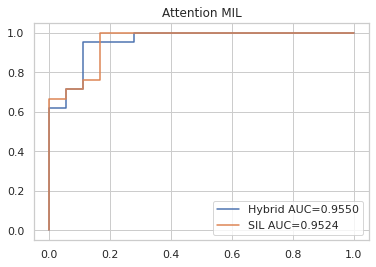

In [31]:
amnt  = 1
plt.figure()
plt.title(f"Attention MIL")
# wsil_preds = []
# for i in range(39):
#     preds = torch.sum(all_weights[i][0] * F.softmax(all_sil_preds[i], dim=1)[:,1])
#     wsil_preds.append(preds)

wsil_preds = np.array(hybrid_preds)
labels = np.array(all_labels)
hybrid_auc = roc_auc_score(labels, wsil_preds)
sil_auc = roc_auc_score(labels, np.array(sil_preds))
fpr, tpr, thresh = roc_curve(labels, wsil_preds)
plt.plot(fpr, tpr, label=f'Hybrid AUC={hybrid_auc:.4f}')

fpr, tpr, thresh = roc_curve(labels, np.array(sil_preds))
plt.plot(fpr, tpr, label=f'SIL AUC={sil_auc:.4f}')

acc = np.mean(np.round(wsil_preds) == labels)
print("Hybrid ACC=" + str(acc))
acc = np.mean(np.round(np.array(sil_preds)) == labels)
print("SIL ACC=" + str(acc))
plt.legend()

In [25]:
sil_pred

0.22127149950853828

In [26]:
mil_pred

0.00022381291

MISL ACC=0.8461538461538461


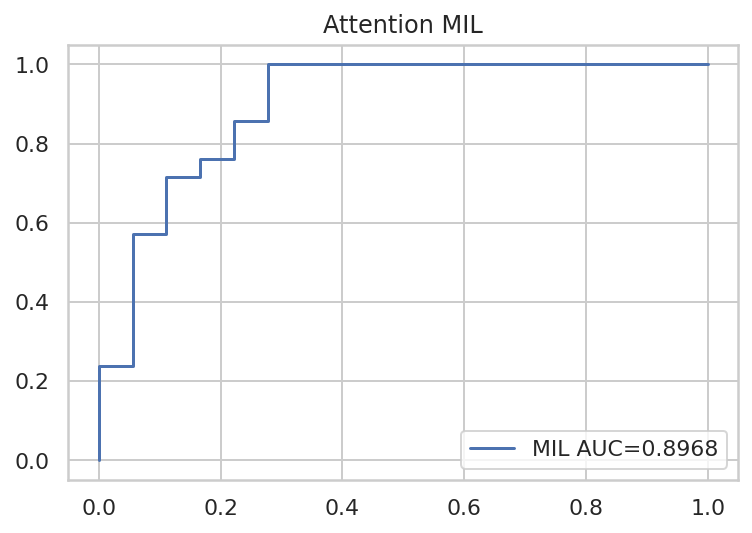

In [113]:
amnt  = 1
plt.figure()
plt.title(f"Attention MIL")
# wsil_preds = []
# for i in range(39):
#     preds = torch.sum(all_weights[i][0] * F.softmax(all_sil_preds[i], dim=1)[:,1])
#     wsil_preds.append(preds)

wsil_preds = np.array(all_preds)
labels = np.array(all_labels)
auc = roc_auc_score(labels, wsil_preds)
fpr, tpr, thresh = roc_curve(labels, wsil_preds)

plt.plot(fpr, tpr, label=f'MIL AUC={auc:.4f}')

acc = np.mean(np.round(wsil_preds) == labels)
print("MISL ACC=" + str(acc))
plt.legend()

In [99]:
all_preds

[0.018474935]

In [100]:
all_labels

[tensor([1])]

In [92]:
F.softmax(mil_classification, dim=-1)[0,0].cpu()

tensor(0.4309)

In [95]:
torch.stack(patient_classifications).cpu().view(groups)

tensor([0.0717, 0.0052, 0.0104, 0.0700, 0.0099, 0.0146, 0.0100, 0.0235, 0.0622,
        0.0127, 0.0323, 0.0268, 0.0209, 0.0073])

In [14]:
unique_ids = [get_unique_id(f[0]) for f in filenames]

In [17]:
with torch.no_grad():
    wbc_preds = wbc_model(all_images[3:4])

In [18]:
cell_types[np.argmax(wbc_preds.numpy(), axis=-1)[0]]

'platelet'

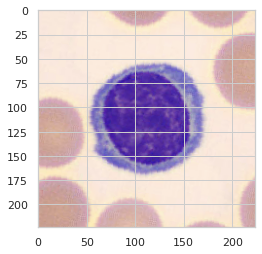

In [19]:
plt.imshow(denormalize_image(all_images[3]))

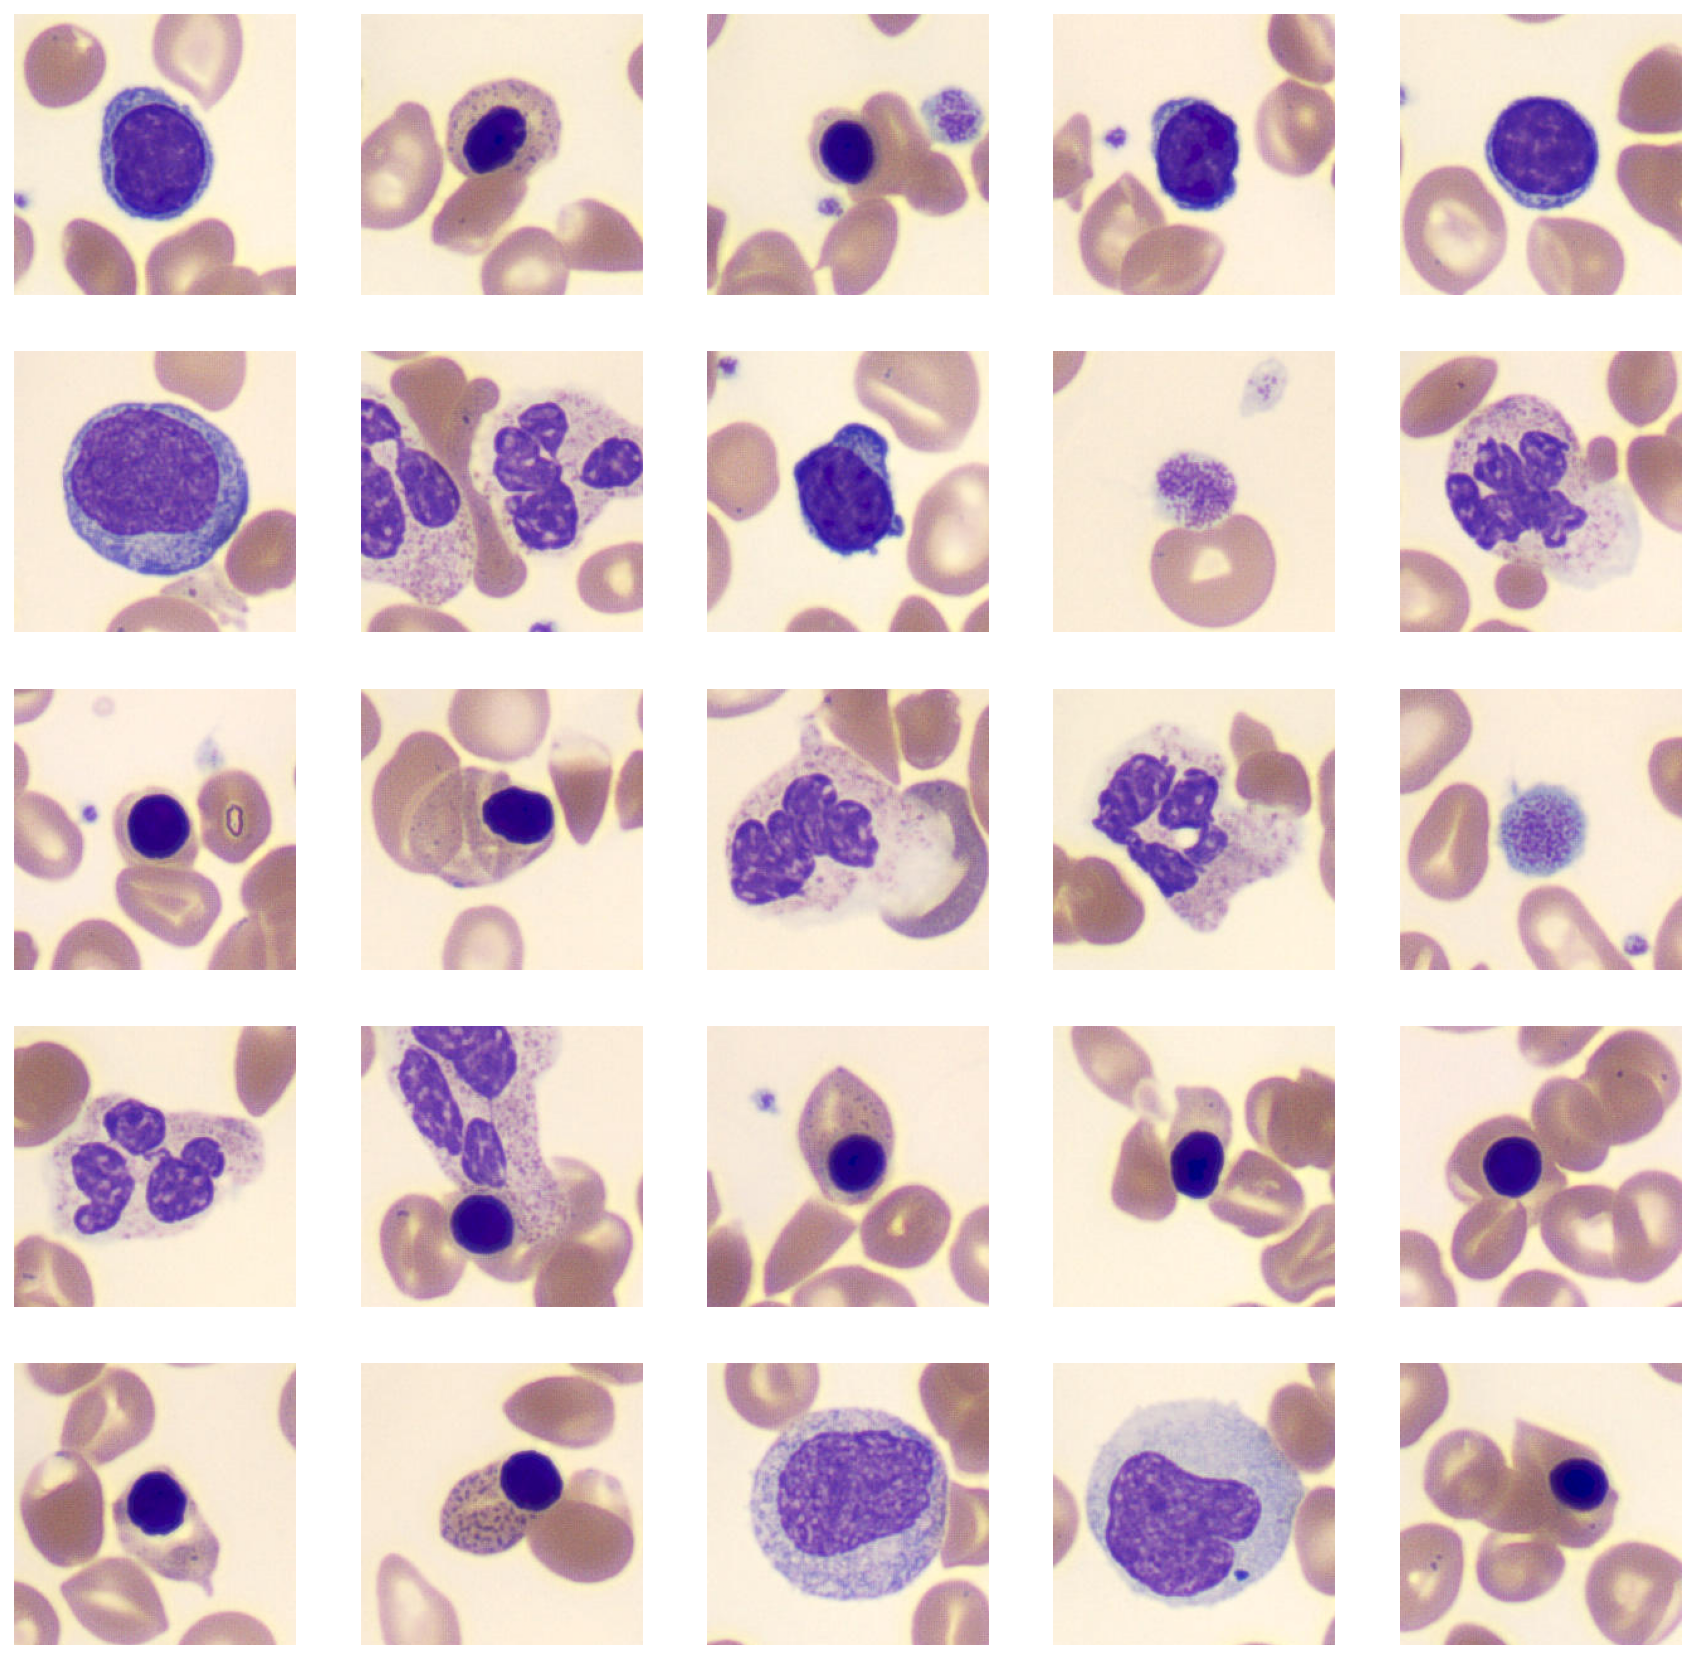

In [65]:
subsampled_inds = np.random.choice(np.arange(0, all_images.shape[0]), size=25, replace=False).tolist()
# top 13
# bottom 12
unique_ids = [get_unique_id(f[0]) for f in filenames]
wbc_types = np.argmax(wbc_preds.numpy(), axis=-1)
all_inds = sorted(np.arange(0, all_images.shape[0]).tolist(), key=lambda x: -attention[0,x])
# inds = all_inds[0:13] + all_inds[-12:]
top_inds = all_inds[0:25]

bottom_inds = all_inds[-25:]


middle = int(len(all_inds)//2)
middle_inds = all_inds[middle - 12:middle +13]

# inds = top_inds
# inds = middle_inds
inds = bottom_inds
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
counter = 0
for si in inds:
    weight = attention[0,si]
    pred_type = cell_types2[wbc_types[si]]
    image = denormalize_image(all_images[si])
    ax = axs[counter //5, counter % 5]
    ax.imshow(image)
    ax.axis('off')
#     ax.set_title(f"{pred_type}:\n {weight:.3f}")
    counter += 1

In [28]:
weights_by_cell_type = {cell_type:[] for cell_type in cell_types2}
all_scores = []
neg_types = []
pos_types = []
all_types = []
def score_to_perc(score):
    return np.sum(np.array(all_scores) < score) / len(all_scores)

for i in range(len(all_attention)):
    for j in range(len(all_wbc_preds[i])):
        score = float(all_attention[i][0,j])
        all_scores.append(score)
pos_percs = []
neg_percs = []
all_percs = []    
weights_by_cell_type_pos = {cell_type:[] for cell_type in cell_types2}
weights_by_cell_type_neg = {cell_type:[] for cell_type in cell_types2}
for i in range(len(all_attention)):
    lab = int(all_labels[i])
    for j in range(len(all_wbc_preds[i])):
        pred_type = cell_types2[np.argmax(all_wbc_preds[i][j].numpy())]
        score = float(all_attention[i][0,j])
        perc = score_to_perc(score)
        all_percs.append(perc)
        
        weights_by_cell_type[pred_type].append(perc)
        if lab == 0:
            neg_percs.append(perc)
            neg_types.append(pred_type)
            weights_by_cell_type_neg[pred_type].append(perc)
        else:
            pos_percs.append(perc)
            pos_types.append(pred_type)
            weights_by_cell_type_pos[pred_type].append(perc)
        all_types.append(pred_type)

In [33]:
from natsort import natsorted

In [36]:
all_types, all_percs = zip(*natsorted(zip(all_types, all_percs), key=lambda x: x[0]))
pos_types, pos_percs = zip(*natsorted(zip(pos_types, pos_percs), key=lambda x: x[0]))
neg_types, neg_percs = zip(*natsorted(zip(neg_types, neg_percs), key=lambda x: x[0]))

In [37]:
import pandas as pd

In [38]:
data_frame_data = {
    'Cell Type': all_types,
    'Score Percentile': all_percs
}

data_frame_data_pos = {
    'Cell Type': pos_types,
    'Score Percentile': pos_percs
}

data_frame_data_neg = {
    'Cell Type': neg_types,
    'Score Percentile': neg_percs
}

In [39]:
dataframe = pd.DataFrame(data_frame_data)
dataframe_pos = pd.DataFrame(data_frame_data_pos)
dataframe_neg = pd.DataFrame(data_frame_data_neg)

In [133]:
sns.set()

In [40]:
mpl.rcParams['figure.dpi'] = 144

Text(0.5, 1.0, 'COVID Positive Patients')

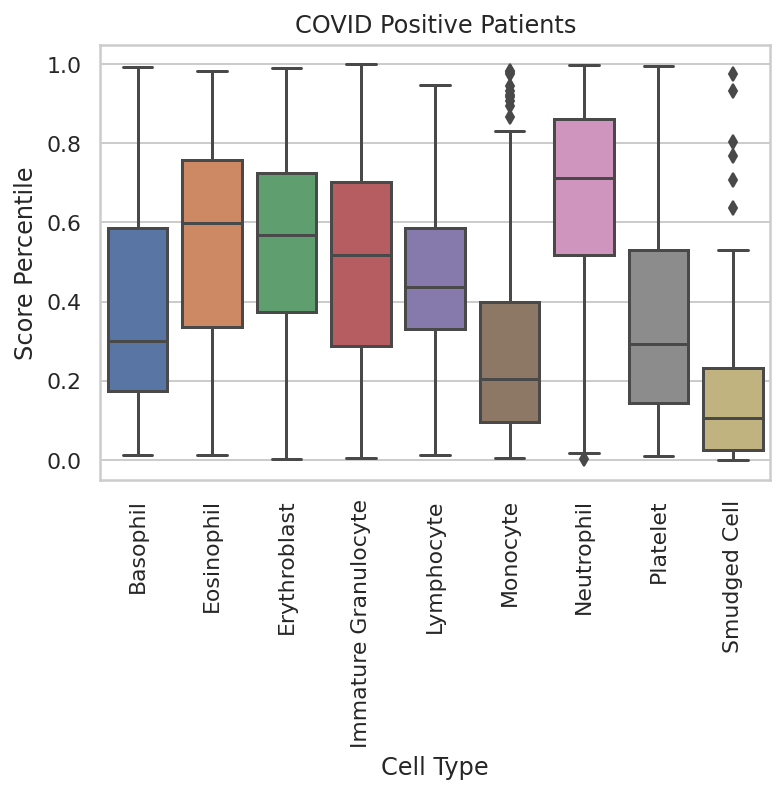

In [44]:
g = sns.boxplot(y=dataframe_pos['Score Percentile'], x=dataframe_pos['Cell Type'], orient='v')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("COVID Positive Patients")

Text(0.5, 1.0, 'COVID Negative Patients')

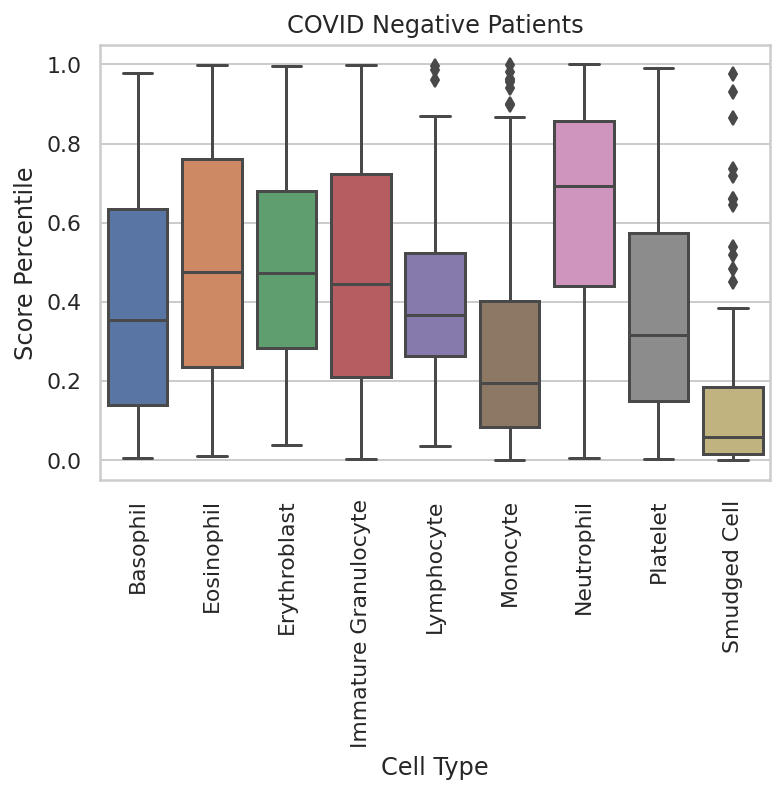

In [45]:
g = sns.boxplot(y=dataframe_neg['Score Percentile'], x=dataframe_neg['Cell Type'], orient='v')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("COVID Negative Patients")

Text(0.5, 1.0, 'All Patients')

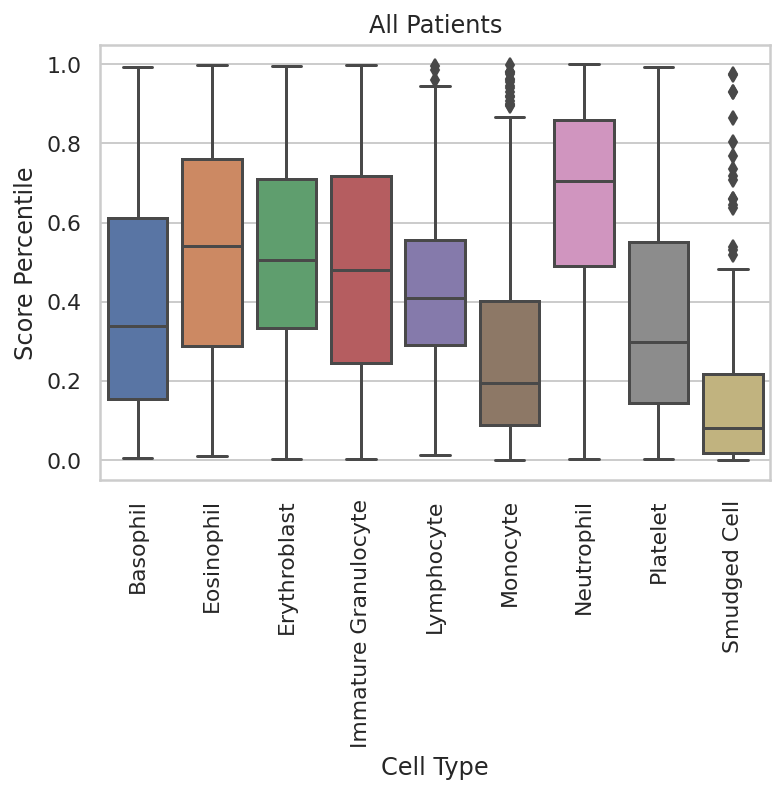

In [46]:
g = sns.boxplot(y=dataframe['Score Percentile'], x=dataframe['Cell Type'], orient='v')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("All Patients")

In [ ]:
plt.boxplot()

In [76]:
box_data = [weights_by_cell_type[c] for c in cell_types]

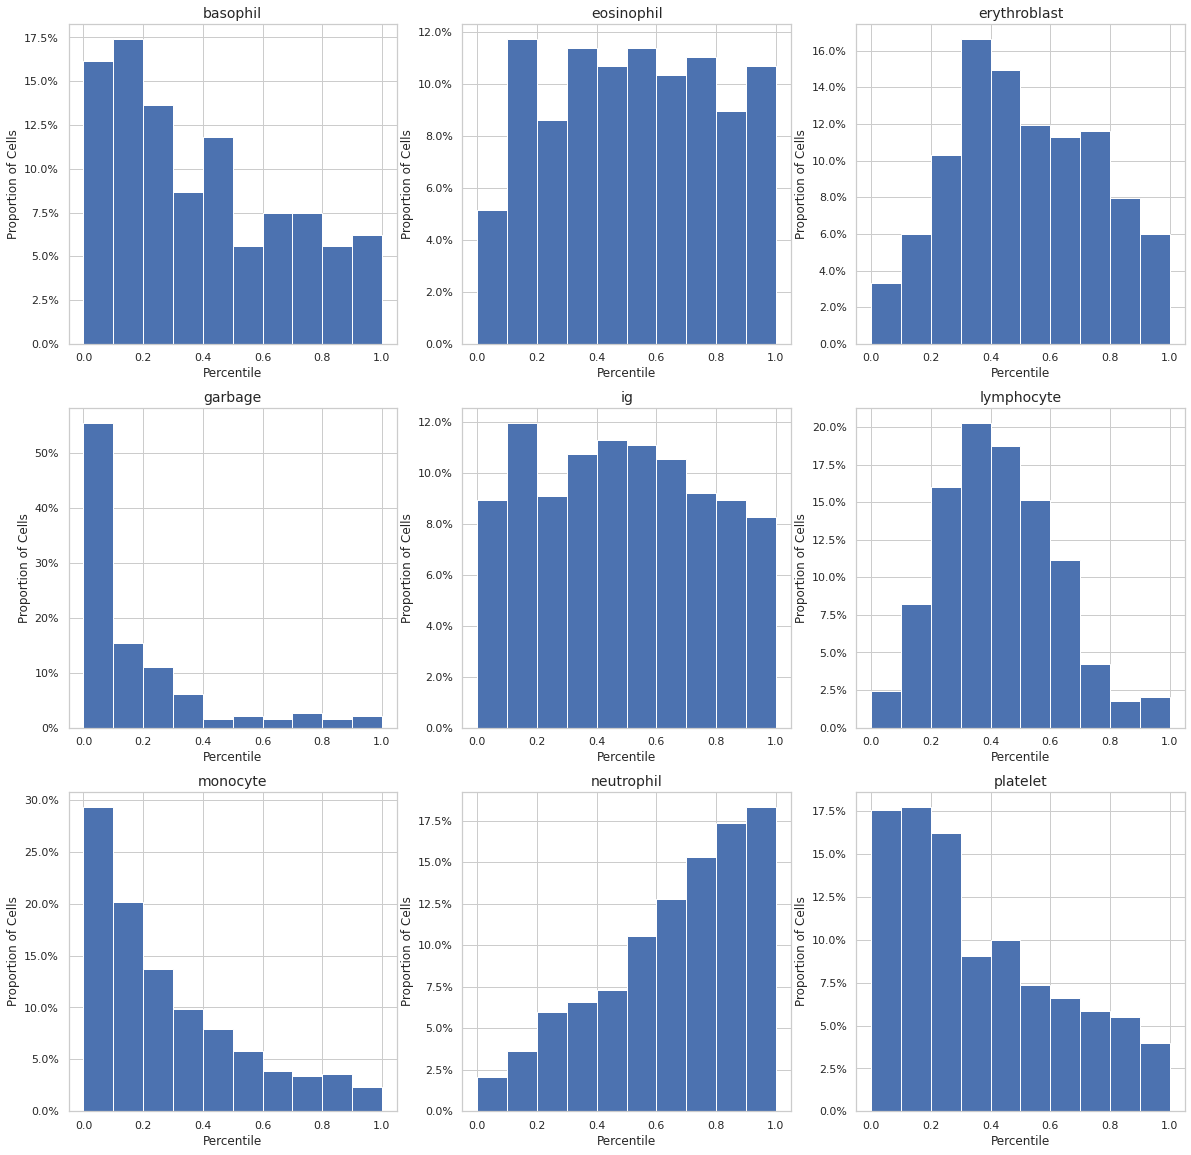

In [66]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
bins = np.linspace(0, 1, 11)
bar_locations = np.linspace(0.05, 0.95, 10)
for i in range(9):
    ax = axs[i//3, i%3]
    cell_type = cell_types[i]
    ax.set_title(cell_type, fontsize=14)
    scores = weights_by_cell_type[cell_type]
    counts, edges = np.histogram(scores, bins)
#     ax.hist(weights_by_cell_type[cell_type], bins=bins, density=False)
    ax.bar(bar_location, counts/np.sum(counts), width=0.1)
    ax.set_xlabel("Percentile")
    ax.set_ylabel("Proportion of Cells")
#     ax.set_ylim(0, 0.5)
    ax.yaxis.set_major_formatter(PercentFormatter(1))

In [24]:
image = denormalize_image(all_images[1])

In [25]:
cell_types[np.argmax(F.softmax(wbc_preds[1], dim=0).numpy())]

'monocyte'

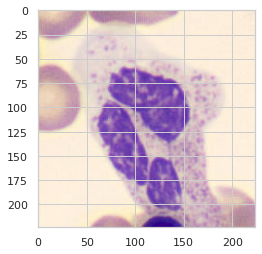

In [26]:
plt.imshow(image)

In [114]:
sample_weights = attention_weights.view(-1).numpy()

In [108]:
sample_weights.shape

(135,)

Text(0.5, 1.0, 'Weight Distribution - Sample 2')

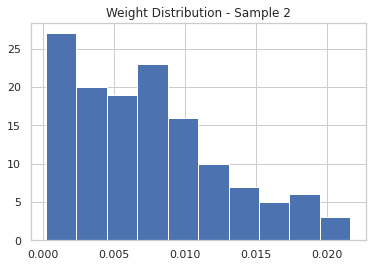

In [117]:
plt.hist(sample_weights)
plt.title("Weight Distribution - Sample 2")

MISL ACC=0.7692307692307693


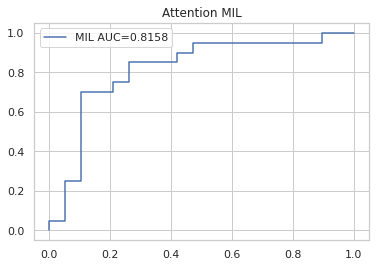

In [94]:
amnt  = 1
plt.figure()
plt.title(f"Attention MIL")
wsil_preds = []
for i in range(39):
    preds = torch.sum(all_weights[i][0] * F.softmax(all_sil_preds[i], dim=1)[:,1])
    wsil_preds.append(preds)

wsil_preds = np.array(wsil_preds)
labels = np.array(all_labels)
auc = roc_auc_score(labels, wsil_preds)
fpr, tpr, thresh = roc_curve(labels, all)

plt.plot(fpr, tpr, label=f'MIL AUC={auc:.4f}')

acc = np.mean(np.round(wsil_preds) == labels)
print("MISL ACC=" + str(acc))
plt.legend()

In [101]:
test = [np.median(F.softmax(sil_preds, dim=-1)[:,1].numpy()) for sil_preds in all_sil_preds]

In [102]:
roc_auc_score(labels, test)

0.8157894736842106

In [99]:
labels = np.array(all_labels)
confs = [F.softmax(p, dim=-1)[0,1] for p in all_preds]

MIL ACC=0.6923076923076923


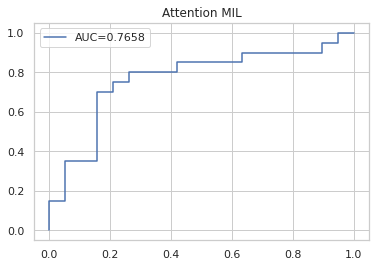

In [100]:
auc = roc_auc_score(labels, confs)
fpr, tpr, thresh = roc_curve(labels, confs)
plt.figure()
plt.title("Attention MIL")
plt.plot(fpr, tpr, label=f'AUC={auc:.4f}')
plt.legend()

acc = np.mean(np.round(confs) == labels)
print("MIL ACC=" + str(acc))

In [14]:
baseline_runs_s = baseline_runs[0:1]

In [15]:
mega_fold = create_mega_fold(baseline_runs_s)

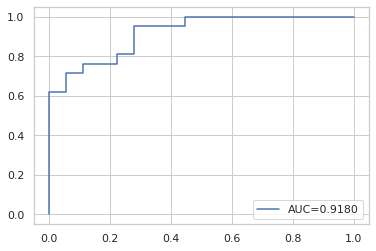

In [25]:
baseline_auc, baseline_acc = process_fold(create_mega_fold(f3_runs[0:1]), make_auc_plot=True)

In [16]:
import seaborn as sns
#sns.reset_defaults()
sns.set(style='whitegrid')
mpl.rcParams['figure.dpi'] = 300

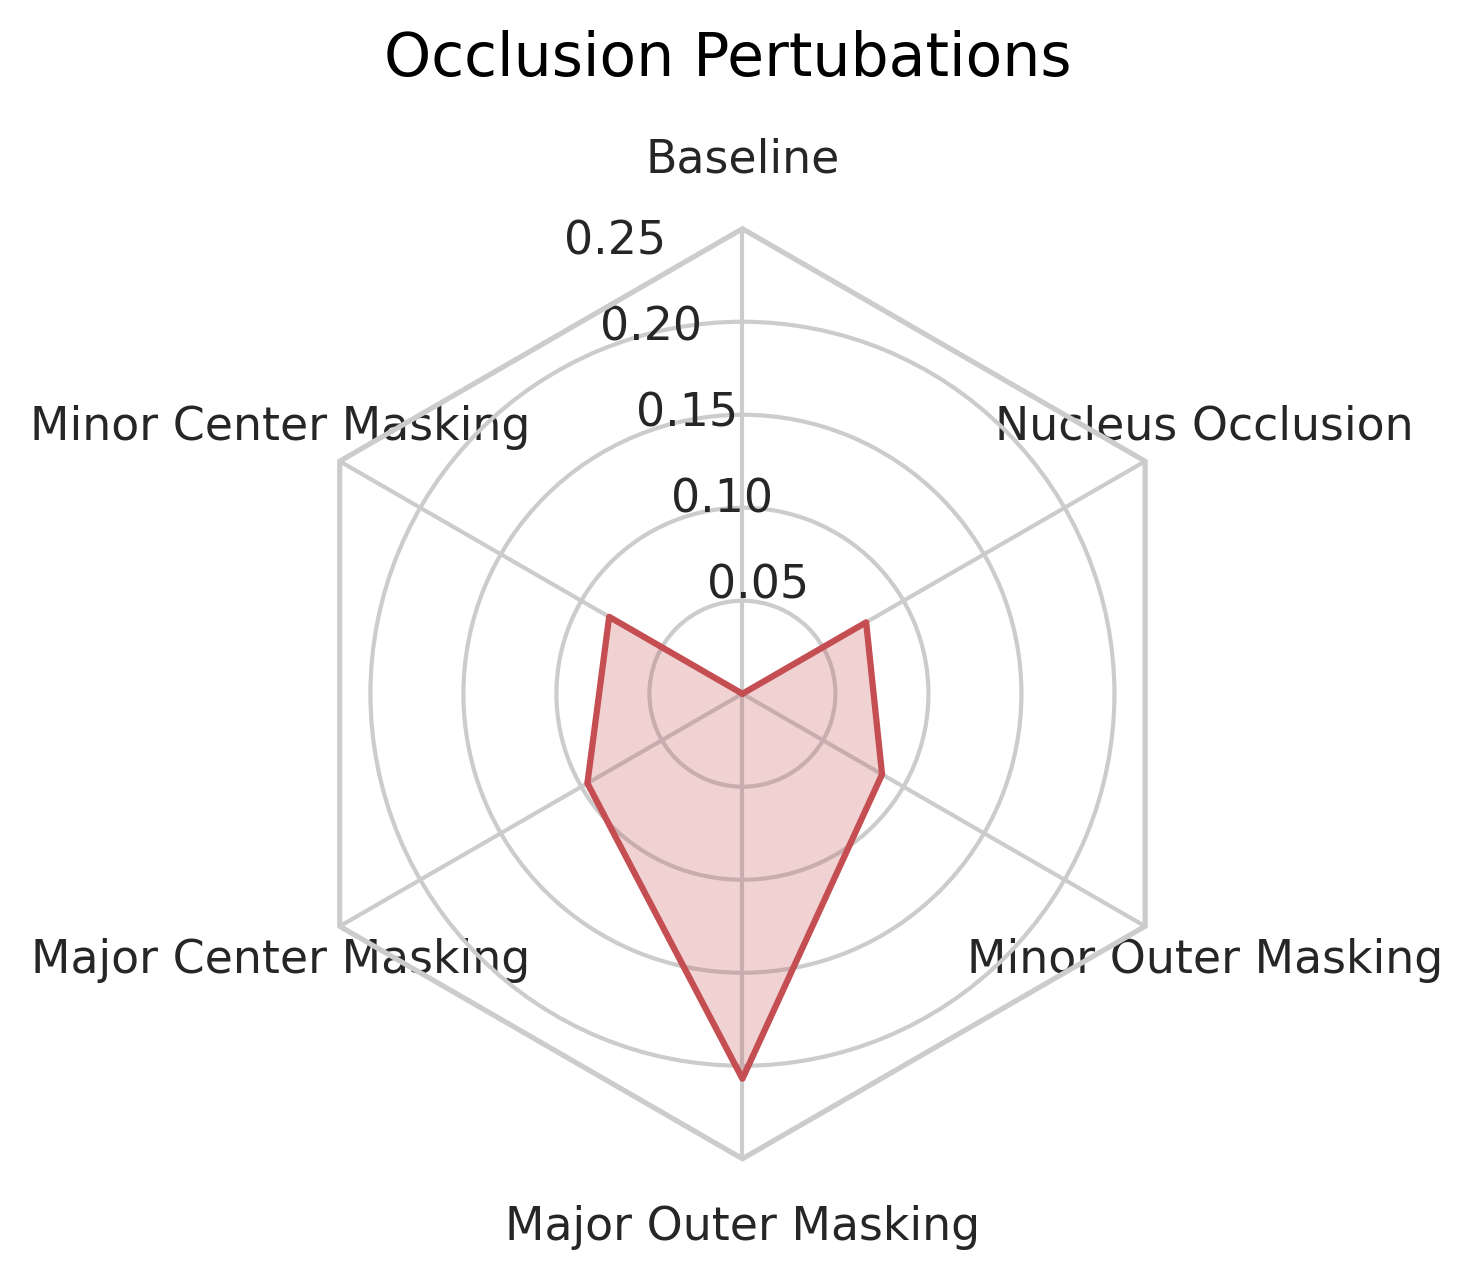

In [18]:
auc_vals = baseline_auc \
    - np.array([baseline_auc, mask_32_auc, mask_96_auc, outer_128_auc, outer_200_auc, nucseg_auc])
pert_names =   ['Baseline', 'Minor Center Masking', 'Major Center Masking', 'Major Outer Masking', 'Minor Outer Masking', 'Nucleus Occlusion']
N = len(pert_names)
theta = radar_factory(N, frame='polygon')

spoke_labels = pert_names

fig, axes = plt.subplots(figsize=(4, 4), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))

fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
color = 'r'
ax = axes
ax.set_rmax(0.21)
ax.set_autoscale_on(False)
ax.set_rgrids([0.05, 0.1, 0.15, 0.2, 0.25])
ax.plot(theta, auc_vals, color=color)
ax.fill(theta, auc_vals, facecolor=color, alpha=0.25)
ax.set_varlabels(spoke_labels)

fig.text(0.5, 0.965, 'Occlusion Pertubations',
            horizontalalignment='center', color='black',
            size='large')
plt.show()

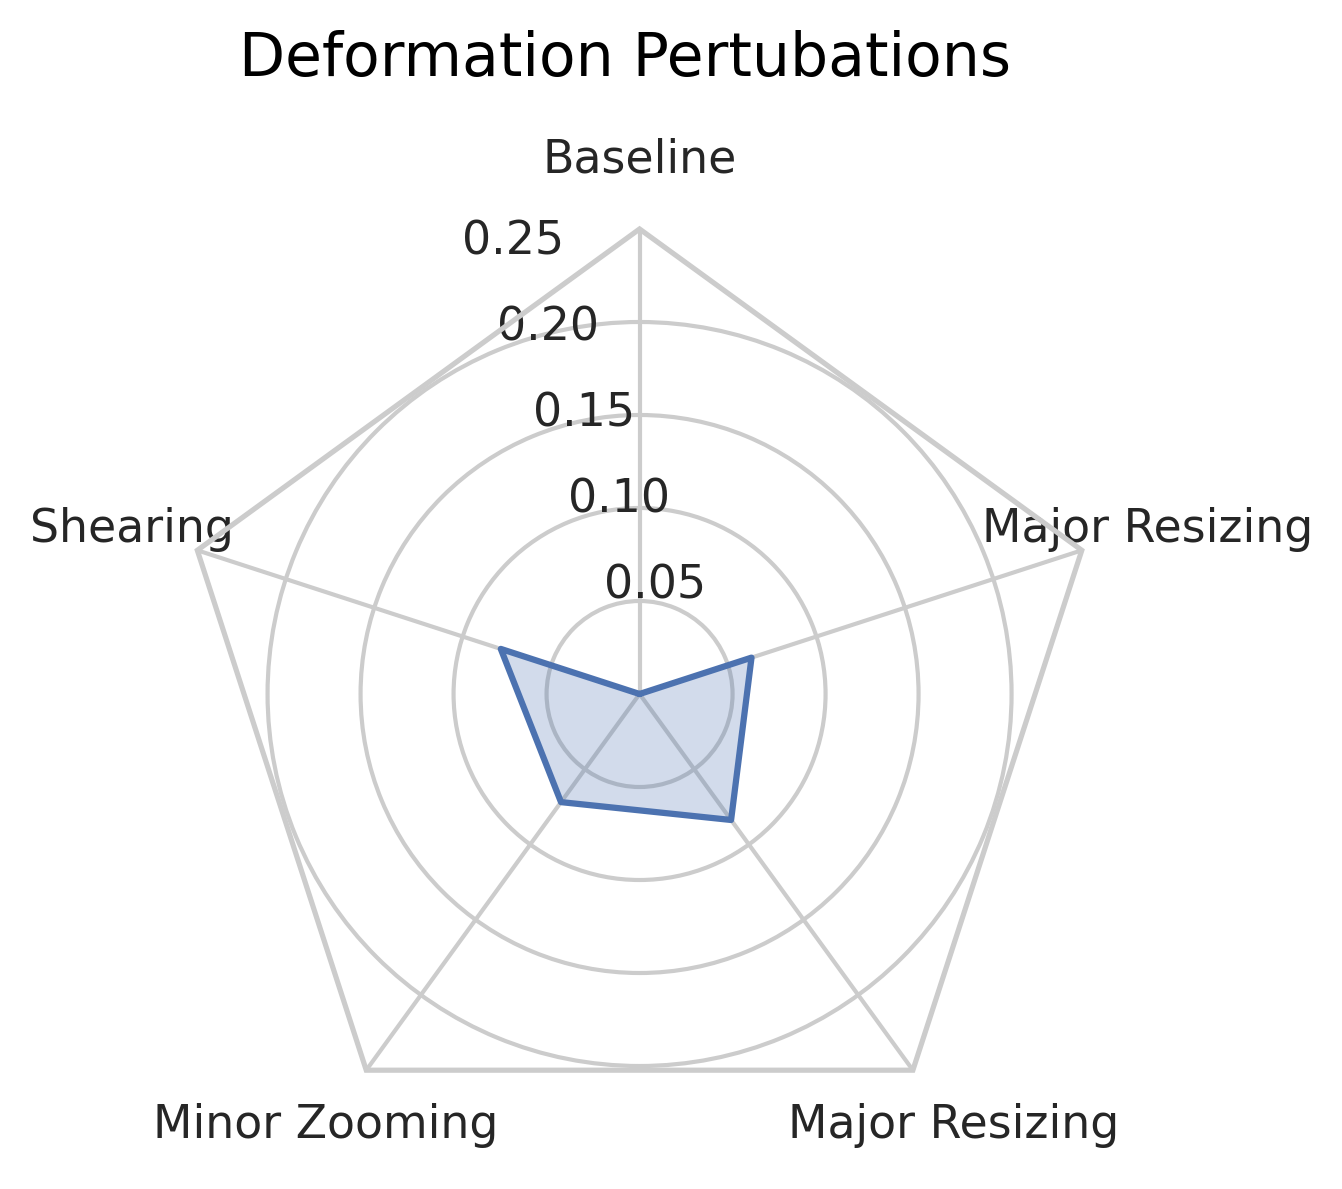

In [19]:
auc_vals = baseline_auc \
    - np.array([baseline_auc, shear_1_auc, zoom_01_auc, resize_32_auc, resize_128_auc])
pert_names =   ['Baseline', 'Shearing', 'Minor Zooming', 'Major Resizing', 'Major Resizing']
N = len(pert_names)
theta = radar_factory(N, frame='polygon')

spoke_labels = pert_names

fig, axes = plt.subplots(figsize=(4, 4), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))

fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
color = 'b'
ax = axes
ax.set_rmax(0.21)
ax.set_autoscale_on(False)
ax.set_rgrids([0.05, 0.1, 0.15, 0.2, 0.25])
ax.plot(theta, auc_vals, color=color)
ax.fill(theta, auc_vals, facecolor=color, alpha=0.25)
ax.set_varlabels(spoke_labels)

fig.text(0.5, 0.965, 'Deformation Pertubations',
            horizontalalignment='center', color='black',
            size='large')
plt.show()

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

